In [1]:
# ========== 1. 环境与依赖 ==========
import os, json, warnings
warnings.simplefilter("ignore", FutureWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import shap, math
import matplotlib as mpl


from matplotlib import rcParams
from IPython.display import display
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score, confusion_matrix, precision_score, make_scorer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from scipy.stats import gaussian_kde
from sklearn.utils import check_random_state
from matplotlib.lines import Line2D
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer  
from sklearn.base import clone
from tqdm import tqdm
from scipy.special import logit, expit
from numpy.random import default_rng
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import Lasso
from sklearn.metrics import log_loss, f1_score


# 统一使用一个随机种子
RANDOM_STATE = 2025
np.random.seed(RANDOM_STATE)

def setup_chinese_fonts():
    """
    配置matplotlib支持中文显示
    """
    # 方案1：使用系统中文字体（推荐）
    try:
        rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'Microsoft YaHei']
        rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
        print("✅ 中文字体配置成功")
    except Exception as e:
        print(f"⚠️ 中文字体配置失败: {e}")
        print("   使用英文标签作为备选方案")

# 立即配置
setup_chinese_fonts()

✅ 中文字体配置成功


In [2]:
# ========== 2. 读取数据 ==========
DATA_PATH = r"C:/Users/VVai/Desktop/output/清洗/整合数据整理/output_with_CCI_total.csv"

# ⚠️ 重要：明确您的目标变量
# 选项 1：预测 ICU 入住 → TARGET = "ICU_flag"
# 选项 2：预测死亡     → TARGET = "death_flag"
TARGET = "death_flag"  # 🔴 根据您的研究目标修改这里

df = pd.read_csv(DATA_PATH)
print("数据形状:", df.shape)
print("列名(预览)前30个:", list(df.columns)[:30])
assert TARGET in df.columns, f"未找到目标变量列 {TARGET}"

# 候选特征(存在即用)
candidate_cols = [
    # 基本信息
    "age", "gender",

    # 体格信息
    "Height", "Height (Inches)", "Weight", "Weight (Lbs)", "BMI", "BMI (kg/m2)",

    # 血压
    "Diastolic blood pressure", "Systolic blood pressure",

    # 甲功相关
    "TSH(uIU/mL)", "FT4(pmol/L)", "TSHI", "TT4RI", "PHI(lnTsh)", "PTFQI", "TSH index",

    # 血液/生化指标
    "RBC(m/uL)", "WBC(K/uL)", "PLT", "Hb(g/dL)", "Glucose(mg/dL)",
    "Creatinine(mg/dL)", "BUN(mg/dL)", "ALT(IU/L)", "AST", "PT",

    # 疾病/并发症
    "Hypertension", "Diabetes", "CKD", "Myocardial infarct",
    "Congestive heart failure", "Malignant cancer", "COPD",

    # 住院信息（根据目标变量调整）
    "CCI Score",
]

# ✅ 关键步骤：从特征中排除目标变量
feature_cols = [c for c in candidate_cols if c in df.columns and c != TARGET]

# ✅ 安全检查 1：确保目标变量不在特征中
print("\n" + "=" * 60)
print("🔍 安全检查")
print("=" * 60)
print(f"目标变量: {TARGET}")
print(f"候选特征数量: {len(feature_cols)}")

if TARGET in feature_cols:
    print("❌ 严重错误：目标变量出现在特征列表中！")
    print("   这会导致数据泄露，结果完全不可信！")
    raise ValueError(f"目标变量 {TARGET} 不能作为特征！")
else:
    print(f"✅ 通过：目标变量 '{TARGET}' 未出现在特征中")

# ✅ 安全检查 2：打印特征列表供人工审核
print(f"\n用于建模的特征列表 ({len(feature_cols)} 个):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# 性别映射(如是字符串)
if "gender" in feature_cols and df["gender"].dtype == object:
    df["gender"] = df["gender"].map({"M":1, "F":0}).fillna(0).astype(int)
    print("\n✅ 性别已映射: M → 1, F → 0")

# 构建建模数据集
df_model = df[feature_cols + [TARGET]].dropna().copy()
X_all = df_model[feature_cols]
y_all = df_model[TARGET].astype(int)

# ✅ 最终验证
print("\n" + "=" * 60)
print("✅ 数据准备完成")
print("=" * 60)
print(f"样本数量: {X_all.shape[0]}")
print(f"特征数量: {X_all.shape[1]}")
print(f"目标变量: {TARGET}")
print(f"\n目标变量分布:")
print(y_all.value_counts())
print(f"正类比例: {y_all.mean():.2%}")

# ✅ 最后检查：确认 X_all 中没有目标变量
if TARGET in X_all.columns:
    raise ValueError(f"❌ 致命错误：目标变量 {TARGET} 在特征矩阵中！")
print(f"\n✅ 最终确认：特征矩阵中不含目标变量")
print("=" * 60)

数据形状: (2782, 47)
列名(预览)前30个: ['subject_id', 'gender', 'age', 'hadm_id', 'stay_id', 'admittime', 'dischtime', 'intime', 'outtime', 'deathtime', 'death_date', 'Height', 'Height (Inches)', 'Weight', 'Weight (Lbs)', 'BMI', 'Diastolic blood pressure', 'Systolic blood pressure', 'BMI (kg/m2)', 'TSH(uIU/mL)', 'FT4(pmol/L)', 'TSHI', 'TT4RI', 'RBC(m/uL)', 'WBC(K/uL)', 'PLT', 'Hb(g/dL)', 'Glucose(mg/dL)', 'Creatinine(mg/dL)', 'BUN(mg/dL)']

🔍 安全检查
目标变量: death_flag
候选特征数量: 35
✅ 通过：目标变量 'death_flag' 未出现在特征中

用于建模的特征列表 (35 个):
   1. age
   2. gender
   3. Height
   4. Height (Inches)
   5. Weight
   6. Weight (Lbs)
   7. BMI
   8. BMI (kg/m2)
   9. Diastolic blood pressure
  10. Systolic blood pressure
  11. TSH(uIU/mL)
  12. FT4(pmol/L)
  13. TSHI
  14. TT4RI
  15. PHI(lnTsh)
  16. PTFQI
  17. TSH index
  18. RBC(m/uL)
  19. WBC(K/uL)
  20. PLT
  21. Hb(g/dL)
  22. Glucose(mg/dL)
  23. Creatinine(mg/dL)
  24. BUN(mg/dL)
  25. ALT(IU/L)
  26. AST
  27. PT
  28. Hypertension
  29. Diabetes
  30. CKD

In [3]:
# ============================ 第3步:数据集划分 ============================
# ✅ 修改: 统一使用 RANDOM_STATE

# Step 1: 先划分出测试集(10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_all, y_all,
    test_size=0.1,
    random_state=RANDOM_STATE,  # ✅ 修改: 使用统一的随机种子
    stratify=y_all  # 保证类别比例一致
)

# Step 2: 剩下的 90% 再按 8:1 划分训练集与验证集
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=1/9,   # 90% 的 1/9 ≈ 10%
    random_state=RANDOM_STATE,  # ✅ 修改: 使用统一的随机种子
    stratify=y_temp
)

# 保存副本(用于归一化 / 特征选择)
train_y = y_train.copy()
val_y = y_val.copy()
test_y = y_test.copy()


print("数据集划分完毕:")
print(f"训练集:{X_train.shape}, 验证集:{X_val.shape}, 测试集:{X_test.shape}")

数据集划分完毕:
训练集:(2224, 35), 验证集:(279, 35), 测试集:(279, 35)


In [4]:
# ============================ 第4步:数据预处理 ============================

# ✅ 修复：直接使用最终变量名，避免中间变量
train_X_scaled = X_train.copy()
val_X_scaled = X_val.copy()
test_X_scaled = X_test.copy()

print("=" * 70)
print("开始数据预处理")
print("=" * 70)
print(f"训练集: {train_X_scaled.shape}")
print(f"验证集: {val_X_scaled.shape}")
print(f"测试集: {test_X_scaled.shape}")

# 识别变量类型
binary_cols = []
cont_cols = []

for col in train_X_scaled.columns:
    unique_vals = train_X_scaled[col].dropna().unique()
    if set(unique_vals).issubset({0, 1}) or set(unique_vals).issubset({0.0, 1.0}):
        binary_cols.append(col)
    else:
        cont_cols.append(col)

print(f"\n二分类变量 ({len(binary_cols)}个): {binary_cols}")
print(f"连续变量 ({len(cont_cols)}个): {cont_cols}")

# 缺失值填充
if len(cont_cols) > 0:
    imputer_cont = SimpleImputer(strategy='median')
    train_X_scaled[cont_cols] = imputer_cont.fit_transform(train_X_scaled[cont_cols])
    val_X_scaled[cont_cols] = imputer_cont.transform(val_X_scaled[cont_cols])
    test_X_scaled[cont_cols] = imputer_cont.transform(test_X_scaled[cont_cols])
    print(f"✅ 连续变量缺失值填充完成 (中位数)")

if len(binary_cols) > 0:
    imputer_binary = SimpleImputer(strategy='most_frequent')
    train_X_scaled[binary_cols] = imputer_binary.fit_transform(train_X_scaled[binary_cols])
    val_X_scaled[binary_cols] = imputer_binary.transform(val_X_scaled[binary_cols])
    test_X_scaled[binary_cols] = imputer_binary.transform(test_X_scaled[binary_cols])
    print(f"✅ 二分类变量缺失值填充完成 (众数)")

# 偏斜处理
skew_threshold = 2.0
highly_skewed = []
for col in cont_cols:
    skewness = train_X_scaled[col].skew()
    if abs(skewness) > skew_threshold and train_X_scaled[col].min() >= 0:
        highly_skewed.append(col)

if len(highly_skewed) > 0:
    print(f"\n检测到 {len(highly_skewed)} 个高偏斜变量: {highly_skewed}")
    train_X_scaled[highly_skewed] = np.log1p(train_X_scaled[highly_skewed])
    val_X_scaled[highly_skewed] = np.log1p(val_X_scaled[highly_skewed])
    test_X_scaled[highly_skewed] = np.log1p(test_X_scaled[highly_skewed])
    print(f"✅ 已进行 log1p 转换")

# 标准化 (仅对连续变量)
scaler = RobustScaler()
train_X_scaled[cont_cols] = scaler.fit_transform(train_X_scaled[cont_cols])
val_X_scaled[cont_cols] = scaler.transform(val_X_scaled[cont_cols])
test_X_scaled[cont_cols] = scaler.transform(test_X_scaled[cont_cols])

print(f"\n✅ 预处理完成")
print(f"   - 缺失值填充: ✅")
print(f"   - 偏斜处理: {len(highly_skewed)} 个变量")
print(f"   - 标准化: {len(cont_cols)} 个连续变量")
print("=" * 70)

# ✅ 添加在第4步末尾（"预处理完成"之后）
# 创建变量别名，供后续可视化使用
train_X_imp = train_X_scaled.copy()
val_X_imp = val_X_scaled.copy()
test_X_imp = test_X_scaled.copy()

print(f"✅ 已创建预处理后的数据副本: train_X_imp, val_X_imp, test_X_imp")

开始数据预处理
训练集: (2224, 35)
验证集: (279, 35)
测试集: (279, 35)

二分类变量 (8个): ['gender', 'Hypertension', 'Diabetes', 'CKD', 'Myocardial infarct', 'Congestive heart failure', 'Malignant cancer', 'COPD']
连续变量 (27个): ['age', 'Height', 'Height (Inches)', 'Weight', 'Weight (Lbs)', 'BMI', 'BMI (kg/m2)', 'Diastolic blood pressure', 'Systolic blood pressure', 'TSH(uIU/mL)', 'FT4(pmol/L)', 'TSHI', 'TT4RI', 'PHI(lnTsh)', 'PTFQI', 'TSH index', 'RBC(m/uL)', 'WBC(K/uL)', 'PLT', 'Hb(g/dL)', 'Glucose(mg/dL)', 'Creatinine(mg/dL)', 'BUN(mg/dL)', 'ALT(IU/L)', 'AST', 'PT', 'CCI Score']
✅ 连续变量缺失值填充完成 (中位数)
✅ 二分类变量缺失值填充完成 (众数)

检测到 17 个高偏斜变量: ['Height', 'Height (Inches)', 'Weight', 'Weight (Lbs)', 'BMI', 'BMI (kg/m2)', 'TSH(uIU/mL)', 'FT4(pmol/L)', 'TT4RI', 'RBC(m/uL)', 'WBC(K/uL)', 'Glucose(mg/dL)', 'Creatinine(mg/dL)', 'BUN(mg/dL)', 'ALT(IU/L)', 'AST', 'PT']
✅ 已进行 log1p 转换

✅ 预处理完成
   - 缺失值填充: ✅
   - 偏斜处理: 17 个变量
   - 标准化: 27 个连续变量
✅ 已创建预处理后的数据副本: train_X_imp, val_X_imp, test_X_imp


In [5]:
# ============================ 第5步:Boruta 特征选择 ============================

print("=" * 50)
print("开始 Boruta 特征选择")
print("=" * 50)

# Boruta 参数设置
selector = BorutaPy(
    RandomForestClassifier(
        n_jobs=-1, 
        class_weight='balanced', 
        max_depth=5,
        random_state=RANDOM_STATE
    ),
    n_estimators='auto',
    verbose=2,
    random_state=RANDOM_STATE
)

# 在训练集上进行特征选择
selector.fit(train_X_scaled.values, train_y.values)

# 获取选中的特征
selected_features = train_X_scaled.columns[selector.support_].tolist()
tentative_features = train_X_scaled.columns[selector.support_weak_].tolist()
selected_all = selected_features + tentative_features

print("\n" + "=" * 50)
print(f"✅ Boruta 特征选择完成")
print("=" * 50)
print(f"确认选中的特征 ({len(selected_features)}): {selected_features}")
print(f"待定特征 ({len(tentative_features)}): {tentative_features}")
print(f"最终使用的特征总数 ({len(selected_all)}): {selected_all}")

# 保存特征选择结果
feature_importance = pd.DataFrame({
    'Feature': train_X_scaled.columns,
    'Selected': selector.support_,
    'Tentative': selector.support_weak_,
    'Ranking': selector.ranking_
}).sort_values('Ranking')

print("\n特征重要性排名:")
print(feature_importance.to_string(index=False))

# ✅ 关键步骤：立即应用特征选择，使用统一的变量名
print("\n" + "=" * 50)
print("应用特征选择到所有数据集")
print("=" * 50)

train_X_sel = train_X_scaled[selected_all].copy()
val_X_sel = val_X_scaled[selected_all].copy()
test_X_sel = test_X_scaled[selected_all].copy()

print(f"训练集: {train_X_sel.shape}")
print(f"验证集: {val_X_sel.shape}")
print(f"测试集: {test_X_sel.shape}")

# ✅ 提供给后续步骤使用（统一接口）
X_train_for_models = train_X_sel
X_val_for_models = val_X_sel
X_test_for_models = test_X_sel

print("\n✅ 特征选择后的数据已准备完毕，可用于后续建模")

# ✅ 添加在第5步末尾（"特征选择后的数据已准备完毕"之后）
# 同步更新 _imp 变量（用于后续 SHAP 等可视化）
train_X_imp = train_X_sel.copy()
val_X_imp = val_X_sel.copy()
test_X_imp = test_X_sel.copy()

print(f"✅ 已同步更新: train_X_imp, val_X_imp, test_X_imp（特征选择后）")

开始 Boruta 特征选择
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15
Iteration: 	9 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15
Iteration: 	10 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15
Iteration: 	11 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15
Iteration: 	12 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15
Iteration: 	13 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16
Iteration: 	14 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16
Iteration: 	15 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16
Iteration: 	16 / 100
Confirmed: 	16
Tenta

🎨 Boruta 山脊图可视化
可视化特征数: 16
  - 确认特征: 16
  - 待定特征: 0
迭代次数: 200


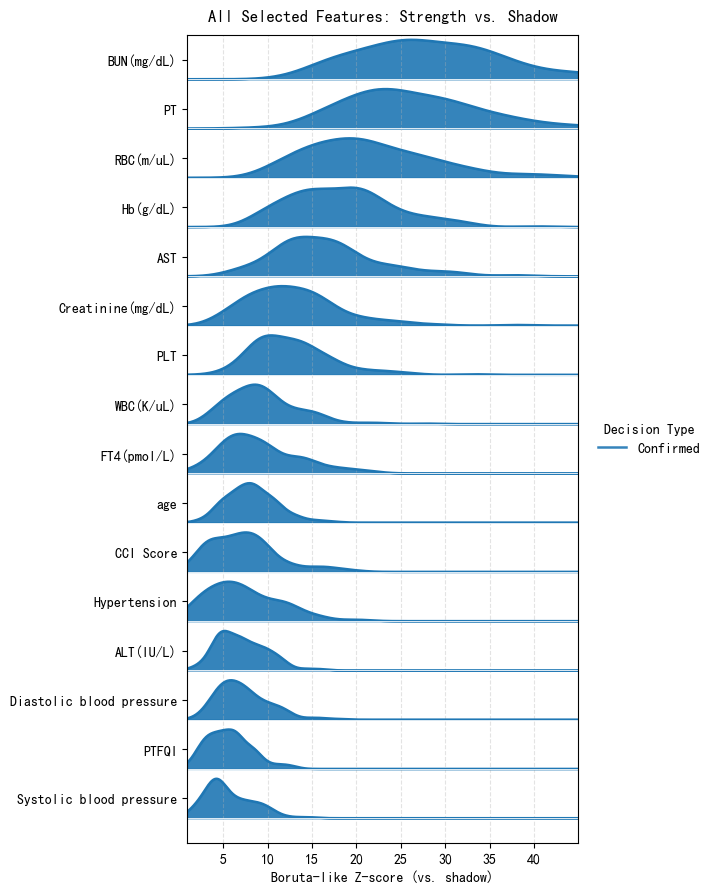

                     feature   decision  count       mean     median       std
0                 BUN(mg/dL)  Confirmed    200  28.675628  27.193334  8.482392
1                         PT  Confirmed    200  26.558967  25.326043  8.223080
2                  RBC(m/uL)  Confirmed    200  21.530557  20.522655  7.095408
3                   Hb(g/dL)  Confirmed    200  18.378203  18.217034  5.820056
4                        AST  Confirmed    200  16.610670  15.969862  5.883186
5          Creatinine(mg/dL)  Confirmed    200  12.843124  12.069203  5.221333
6                        PLT  Confirmed    200  12.720430  11.991119  4.439684
7                  WBC(K/uL)  Confirmed    200   9.475852   8.898551  3.993687
8                FT4(pmol/L)  Confirmed    200   9.108012   8.324096  4.311726
9                        age  Confirmed    200   8.223517   8.169472  2.781359
10                 CCI Score  Confirmed    200   7.340909   6.980735  3.825721
11              Hypertension  Confirmed    200   7.2

In [6]:
# ===================== Boruta 内部机制可视化（Z-score 分布 + 山脊图）=====================
# ---------- 可配置 ----------
N_ITERS = 200
SAMPLE_FRAC = 0.8
SEED = 42

# ---------- ✅ 使用建模时相同的特征集 ----------
# ⚠️ 关键修复：使用 selected_all 而不是 selected_features
X_sel = train_X_scaled[selected_all].copy()  # ✅ 修改：使用完整的特征集
y_sel = train_y.copy()

print("=" * 70)
print("🎨 Boruta 山脊图可视化")
print("=" * 70)
print(f"可视化特征数: {len(selected_all)}")
print(f"  - 确认特征: {len(selected_features)}")
print(f"  - 待定特征: {len(tentative_features)}")
print(f"迭代次数: {N_ITERS}")
print("=" * 70)

# ---------- RF 参数 ----------
if 'selector' in globals():
    # 复用 Boruta 中的 RF 参数
    RF_PARAMS = selector.estimator.get_params()
    RF_PARAMS.pop('random_state', None)
else:
    RF_PARAMS = dict(
        n_estimators=300,
        n_jobs=-1,
        max_depth=5,
        class_weight='balanced'
    )

# ---------- 生成 Boruta-like Z-score 分布 ----------
def collect_boruta_like_z(X_df, y, rf_params, n_iters=200, sample_frac=0.8, seed=42):
    rng = default_rng(seed)
    cols = list(X_df.columns)
    n = len(X_df)
    take = max(1, int(n * float(sample_frac)))
    rows = []

    base_params = dict(rf_params)
    base_params.pop("random_state", None)

    for i in tqdm(range(n_iters), desc="Collecting Boruta-like Z"):
        idx = rng.choice(n, take, replace=True)
        Xb = X_df.iloc[idx, :]
        yb = y.iloc[idx]

        X_shadow = pd.DataFrame(index=Xb.index)
        for c in cols:
            shuf = Xb[c].to_numpy().copy()
            rng.shuffle(shuf)
            X_shadow[c + "_shadow"] = shuf

        X_aug = pd.concat([Xb.reset_index(drop=True), X_shadow.reset_index(drop=True)], axis=1)
        rf_local = RandomForestClassifier(**base_params, random_state=int(seed) + i)
        rf_local.fit(X_aug, yb.values)

        imps = pd.Series(rf_local.feature_importances_, index=X_aug.columns)
        imp_real   = imps.loc[cols].values
        imp_shadow = imps.loc[[c + "_shadow" for c in cols]].values

        sh_mean = float(np.mean(imp_shadow))
        sh_std  = float(np.std(imp_shadow))
        if sh_std == 0 or np.isnan(sh_std):
            sh_std = 1e-12
        z = (imp_real - sh_mean) / sh_std

        rows.extend([(f, float(zv), i) for f, zv in zip(cols, z)])

    long_df = pd.DataFrame(rows, columns=["feature", "z", "iter"])
    return long_df

long_borutaZ = collect_boruta_like_z(
    X_df=X_sel, y=y_sel,
    rf_params=RF_PARAMS,
    n_iters=N_ITERS, sample_frac=SAMPLE_FRAC, seed=SEED
)

# ---------- 合并 Boruta 判定结果（用于着色） ----------
decision_map = {}
if 'selector' in globals():  # ✅ 修改：使用正确的变量名
    # True=Confirmed；support_weak_=Tentative；其余视为 Rejected
    confirmed_feats = set(train_X_scaled.columns[np.where(selector.support_)[0]])  # ✅ 修改
    tentative_feats_set = set(train_X_scaled.columns[np.where(selector.support_weak_)[0]])  # ✅ 修改
    for f in X_sel.columns:
        if f in confirmed_feats:
            decision_map[f] = "Confirmed"
        elif f in tentative_feats_set:  # ✅ 改名避免和前面的 tentative_features 冲突
            decision_map[f] = "Tentative"
        else:
            decision_map[f] = "Rejected"
else:
    decision_map = {f: "Tentative" for f in X_sel.columns}

long_borutaZ["decision"] = long_borutaZ["feature"].map(decision_map)

# ---------- 按中位数 Z 排序（画图从上到下更直观） ----------
feat_order = (long_borutaZ.groupby("feature")["z"]
              .median().sort_values(ascending=False).index.tolist())
feats_for_plot = feat_order[::-1]

# ---------- Ridge 山脊图函数 ----------
def ridgeline_plot_borutaZ(df_long, feats,
                           x_label="Boruta-like Z-score (vs. shadow)",
                           title="Distribution of Feature Strength vs. Shadow (Boruta style)"):
    style_map = {
        'Confirmed': {'lw': 1.8, 'alpha': 0.9},
        'Tentative': {'lw': 1.2, 'alpha': 0.75},
        'Rejected' : {'lw': 1.0, 'alpha': 0.55},
    }
    color_map = {
        'Confirmed': '#1f77b4',  # 蓝
        'Tentative': '#9467bd',  # 紫
        'Rejected' : '#7f7f7f',  # 灰
    }

    all_z = df_long['z'].dropna().values
    if len(all_z):
        x_min = float(np.percentile(all_z, 0.5) - 0.5)
        x_max = float(np.percentile(all_z, 99.5) + 0.5)
    else:
        x_min, x_max = -1.0, 1.0
    xs = np.linspace(x_min, x_max, 350)

    fig, ax = plt.subplots(figsize=(8.5, max(4.0, 0.44*len(feats)+2)))
    y_offsets = np.arange(len(feats))

    for y0, f in zip(y_offsets, feats):
        sub = df_long.loc[df_long['feature'] == f]
        dat = sub['z'].dropna().values
        main_dec = sub['decision'].mode().iat[0] if len(sub) and not sub['decision'].mode().empty else 'Tentative'
        style = style_map.get(main_dec, style_map['Tentative'])
        c = color_map.get(main_dec, color_map['Tentative'])

        if len(dat) < 5 or np.allclose(dat, dat[0]):
            xm = float(np.mean(dat)) if len(dat) else 0.0
            ax.plot([xm, xm], [y0, y0+0.85], lw=style['lw'], alpha=style['alpha'], color=c)
            continue

        kde = gaussian_kde(dat)
        ys = kde(xs)
        ys = ys / (ys.max() + 1e-12) * 0.8  # 归一化高度

        ax.fill_between(xs, y0, y0 + ys, alpha=style['alpha'], color=c)
        ax.plot(xs, y0 + ys, lw=style['lw'], color=c)
        ax.plot(xs, [y0]*len(xs), lw=0.6, color='white')

    ax.set_xlabel(x_label)
    ax.set_yticks(y_offsets + 0.4)
    ax.set_yticklabels(feats)
    ax.set_title(title, pad=10)
    ax.grid(True, axis='x', ls='--', alpha=0.35)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-0.5, len(feats) - 0.1)

    handles, labels = [], []
    for k in ['Confirmed', 'Tentative', 'Rejected']:
        if (df_long['decision'] == k).any():
            handles.append(Line2D([0], [0], lw=style_map[k]['lw'], alpha=style_map[k]['alpha'], color=color_map[k]))
            labels.append(k)
    if handles:
        ax.legend(handles, labels, title="Decision Type", loc='center left',
                  bbox_to_anchor=(1.02, 0.5), frameon=False)

    plt.tight_layout(rect=[0, 0, 0.86, 1])
    plt.show()

# ---------- 画图 ----------
ridgeline_plot_borutaZ(
    df_long=long_borutaZ,
    feats=feats_for_plot,
    x_label="Boruta-like Z-score (vs. shadow)",
    title="All Selected Features: Strength vs. Shadow"
)

# ---------- 可选：导出汇总表，便于写报告 ----------
borutaZ_summary = (long_borutaZ
                   .groupby(["feature","decision"])["z"]
                   .agg(['count','mean','median','std'])
                   .reset_index()
                   .sort_values("median", ascending=False)).reset_index(drop=True)
print(borutaZ_summary.head(30))

In [7]:
# ===================== 第6步：基于 Boruta 选出的特征，定义模型集合 =====================

print("=" * 70)
print("定义模型集合")
print("=" * 70)

# ✅ 验证数据已准备好（第5步已完成）
print(f"使用特征数量: {X_train_for_models.shape[1]}")
print(f"训练集样本数: {X_train_for_models.shape[0]}")
print(f"验证集样本数: {X_val_for_models.shape[0]}")
print(f"测试集样本数: {X_test_for_models.shape[0]}")

CLASS_WEIGHT = "balanced"

# ---------- 6.1 CV 与评分器 ----------
cv_5x3 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)
auc_scorer = "roc_auc"

# ---------- 6.2 各模型定义 ----------
print("\n定义模型...")

# 1) Logistic Regression
logit = LogisticRegression(
    max_iter=5000, 
    solver="lbfgs",
    class_weight=CLASS_WEIGHT,
    random_state=RANDOM_STATE
)
logit_grid = {"C": [0.0005, 0.001, 0.005]}
logit_gs = GridSearchCV(logit, logit_grid, scoring=auc_scorer,
                        cv=cv_5x3, n_jobs=-1, refit=True,
                        error_score="raise")

# 2) LASSO / Elastic Net
enet = LogisticRegression(
    penalty="elasticnet", 
    solver="saga",
    max_iter=5000,
    class_weight=CLASS_WEIGHT,
    random_state=RANDOM_STATE
)
enet_grid = {
    "l1_ratio": [0.7, 0.9, 1.0],
    "C": [0.0005, 0.001, 0.005]
}
enet_gs = GridSearchCV(enet, enet_grid, scoring=auc_scorer,
                       cv=cv_5x3, n_jobs=-1, refit=True,
                       error_score="raise")

# 3) SVM (RBF)
svm = SVC(
    kernel="rbf", 
    probability=True,
    class_weight=CLASS_WEIGHT,
    random_state=RANDOM_STATE
)
svm_grid = {
    "C": [0.1, 1, 10, 100, 1000],
    "gamma": [0.001, 0.01, 0.1, 0.5, 1.0]
}
svm_gs = GridSearchCV(svm, svm_grid, scoring=auc_scorer,
                      cv=cv_5x3, n_jobs=-1, refit=True,
                      error_score="raise")

# 4) Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    bootstrap=True,
    max_samples=0.5,
    max_leaf_nodes=30,
    max_depth=2,
    min_samples_leaf=20,
    max_features=2,
    class_weight=CLASS_WEIGHT,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_grid = {
    "max_features": [2, 3],
    "min_samples_leaf": [10, 15, 20],
    "min_samples_split": [10, 20]
}
rf_gs = GridSearchCV(rf, rf_grid, scoring=auc_scorer,
                     cv=cv_5x3, n_jobs=-1, refit=True,
                     error_score="raise")

# 5) XGBoost
pos = int(np.sum(train_y == 1))
neg = int(np.sum(train_y == 0))
spw = (neg / max(pos, 1))

xgb = XGBClassifier(
    max_depth=3,
    min_child_weight=30,
    gamma=1.0,
    reg_alpha=2.0,
    reg_lambda=3.0,
    colsample_bytree=0.5,
    subsample=0.5,
    learning_rate=0.02,
    n_estimators=200,
    scale_pos_weight=spw,
    tree_method="hist",
    eval_metric="logloss",
    random_state=RANDOM_STATE
)
xgb_grid = {
    "n_estimators": [100, 300],
    "max_depth": [3, 4],
    "learning_rate": [0.05],
    "min_child_weight": [5, 10]
}
xgb_gs = GridSearchCV(xgb, xgb_grid, scoring=auc_scorer,
                      cv=cv_5x3, n_jobs=-1, refit=True,
                      error_score="raise")

# ---------- 6.3 模型字典 ----------
models = {
    "Logistic": logit_gs,
    "LASSO/ElasticNet": enet_gs,
    "SVM": svm_gs,
    "RandomForest": rf_gs,
    "XGBoost": xgb_gs
}

print(f"\n✅ 模型定义完成")
print(f"将对以下 {len(models)} 个模型进行 5×3 CV 调参：")
for i, name in enumerate(models.keys(), 1):
    print(f"   {i}. {name}")

print("\n" + "=" * 70)

定义模型集合
使用特征数量: 16
训练集样本数: 2224
验证集样本数: 279
测试集样本数: 279

定义模型...

✅ 模型定义完成
将对以下 5 个模型进行 5×3 CV 调参：
   1. Logistic
   2. LASSO/ElasticNet
   3. SVM
   4. RandomForest
   5. XGBoost



In [8]:
# ===================== 第6.5步：辅助函数定义 =====================
# 这些函数将在第7步的模型评估中使用

print("=" * 70)
print("定义评估所需的辅助函数")
print("=" * 70)

def to_score(estimator, X):
    """
    从任意sklearn分类器获取正类概率分数
    兼容Pipeline、CalibratedClassifierCV等
    """
    if hasattr(estimator, 'predict_proba'):
        proba = estimator.predict_proba(X)
        if proba.shape[1] == 2:
            return proba[:, 1]
        else:
            return proba[:, 0]
    elif hasattr(estimator, 'decision_function'):
        return estimator.decision_function(X)
    else:
        return estimator.predict(X)


def youden_threshold(y_true, y_score):
    """
    根据Youden指数（灵敏度+特异度-1的最大值）计算最优分类阈值
    
    Parameters:
    -----------
    y_true : array-like, 真实标签
    y_score : array-like, 预测概率分数
    
    Returns:
    --------
    threshold : float, 最优阈值
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    youden_index = tpr - fpr
    optimal_idx = np.argmax(youden_index)
    optimal_threshold = float(thresholds[optimal_idx])
    return optimal_threshold


def binary_metrics_at(y_true, y_score, threshold):
    """
    在给定阈值下计算二分类的所有性能指标
    
    Parameters:
    -----------
    y_true : array-like, 真实标签 (0/1)
    y_score : array-like, 预测概率分数
    threshold : float, 分类阈值
    
    Returns:
    --------
    accuracy, sensitivity, specificity, ppv, npv : float
    """
    y_true = np.asarray(y_true, dtype=int)
    y_score = np.asarray(y_score, dtype=float)
    
    # 根据阈值进行分类
    y_pred = (y_score >= threshold).astype(int)
    
    # 计算混淆矩阵的各个组成部分
    tp = np.sum((y_pred == 1) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    
    # 计算各项指标
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # 灵敏度
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # 特异度
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0          # 阳性预测值
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0          # 阴性预测值
    
    return float(accuracy), float(sensitivity), float(specificity), float(ppv), float(npv)


def ece_quantile(y_true, y_prob, n_bins=10):
    """
    计算Expected Calibration Error (ECE) - 分位数分箱版本
    
    ECE衡量模型的概率校准质量：
    - ECE越接近0，表示模型的预测概率越准确
    - ECE > 0.1 通常认为校准较差
    
    Parameters:
    -----------
    y_true : array-like, 真实标签 (0/1)
    y_prob : array-like, 预测概率
    n_bins : int, 分箱数量（默认10）
    
    Returns:
    --------
    ece : float, 期望校准误差
    """
    y_true = np.asarray(y_true, dtype=int)
    y_prob = np.asarray(y_prob, dtype=float)
    
    # 使用分位数分箱（更稳健）
    try:
        bin_edges = np.percentile(y_prob, np.linspace(0, 100, n_bins + 1))
        bin_edges[0] = 0.0
        bin_edges[-1] = 1.0
    except:
        bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    
    ece = 0.0
    total_samples = len(y_true)
    
    for i in range(n_bins):
        # 找到落在当前bin中的样本
        bin_mask = (y_prob > bin_edges[i]) & (y_prob <= bin_edges[i + 1])
        
        if i == 0:  # 第一个bin包含左边界
            bin_mask = (y_prob >= bin_edges[i]) & (y_prob <= bin_edges[i + 1])
        
        bin_size = np.sum(bin_mask)
        
        if bin_size > 0:
            bin_prob_mean = np.mean(y_prob[bin_mask])
            bin_true_mean = np.mean(y_true[bin_mask])
            ece += (bin_size / total_samples) * abs(bin_prob_mean - bin_true_mean)
    
    return float(ece)


定义评估所需的辅助函数


In [9]:
def auc_ci_bootstrap(y_true, y_score, n_boot=1000, seed=42, alpha=0.95):
    """
    使用 Bootstrap 重采样方法计算 AUC 的置信区间（超鲁棒版本）
    能够处理采样失败、空数组等各种异常情况
    """
    # === 第0步：类型转换和安全检查 ===
    y_true = np.asarray(y_true, dtype=int)
    y_score = np.asarray(y_score, dtype=float)
    
    # 检查长度匹配
    if len(y_true) != len(y_score):
        print(f"❌ 错误: y_true 和 y_score 长度不匹配 ({len(y_true)} vs {len(y_score)})")
        return np.nan, np.nan
    
    # 检查是否有 NaN 或 Inf
    if np.any(np.isnan(y_score)) or np.any(np.isinf(y_score)):
        print(f"❌ 错误: y_score 包含 NaN 或 Inf")
        return np.nan, np.nan
    
    rng = np.random.RandomState(seed)
    n = len(y_true)
    
    # === 第1步：数据完整性检查 ===
    if n < 10:
        print(f"⚠️ 样本数太少 (n={n})，使用点估计")
        try:
            auc = roc_auc_score(y_true, y_score)
            return float(auc), float(auc)
        except Exception as e:
            print(f"❌ 计算AUC失败: {e}")
            return np.nan, np.nan
    
    # 检查类别分布
    unique_classes = np.unique(y_true)
    if len(unique_classes) < 2:
        print(f"❌ 只有单一类别: {unique_classes}，无法计算AUC")
        return np.nan, np.nan
    
    # 统计每个类别的样本数
    n_pos = int(np.sum(y_true == 1))
    n_neg = int(np.sum(y_true == 0))
    
    if n_pos < 2 or n_neg < 2:
        print(f"⚠️ 某个类别样本太少 (正类:{n_pos}, 负类:{n_neg})，使用点估计")
        try:
            auc = roc_auc_score(y_true, y_score)
            return float(auc), float(auc)
        except:
            return np.nan, np.nan
    
    # === 第2步：执行分层 Bootstrap ===
    aucs = []
    failed_count = 0
    
    # 获取正负类索引
    pos_idx = np.where(y_true == 1)[0]
    neg_idx = np.where(y_true == 0)[0]
    
    for i in range(n_boot):
        try:
            # 分层采样：从正负类中分别采样，确保每次都有两个类别
            boot_pos_idx = rng.choice(pos_idx, size=len(pos_idx), replace=True)
            boot_neg_idx = rng.choice(neg_idx, size=len(neg_idx), replace=True)
            
            # 合并索引
            boot_idx = np.concatenate([boot_pos_idx, boot_neg_idx])
            
            # 计算 AUC
            auc = roc_auc_score(y_true[boot_idx], y_score[boot_idx])
            
            # 检查 AUC 是否有效
            if np.isnan(auc) or np.isinf(auc):
                failed_count += 1
                continue
            
            aucs.append(float(auc))
            
        except Exception as e:
            failed_count += 1
            continue
    
    # === 第3步：结果验证和处理 ===
    success_count = len(aucs)
    success_rate = success_count / n_boot if n_boot > 0 else 0
    
    # 如果完全失败
    if success_count == 0:
        print(f"❌ 所有 {n_boot} 次 Bootstrap 采样都失败")
        print(f"   数据信息: n={n}, 正类={n_pos}, 负类={n_neg}")
        print(f"   y_score 范围: [{np.min(y_score):.4f}, {np.max(y_score):.4f}]")
        
        # 尝试直接计算全数据 AUC
        try:
            auc = roc_auc_score(y_true, y_score)
            print(f"   ✅ 使用全数据AUC作为替代: {auc:.4f}")
            return float(auc), float(auc)
        except Exception as e:
            print(f"   ❌ 全数据AUC计算也失败: {e}")
            return np.nan, np.nan
    
    # 如果成功率过低（但不是0）
    if success_rate < 0.5:
        print(f"⚠️ Bootstrap 成功率较低: {success_rate:.1%} ({success_count}/{n_boot})")
    
    # === 第4步：计算置信区间 ===
    aucs = np.array(aucs, dtype=float)
    
    # 再次检查数组是否有效（防御性编程）
    if len(aucs) == 0:
        print("❌ aucs 数组为空（不应该到这里）")
        return np.nan, np.nan
    
    # 计算百分位数
    lower_percentile = ((1.0 - alpha) / 2.0) * 100
    upper_percentile = (alpha + (1.0 - alpha) / 2.0) * 100
    
    try:
        ci_lower = float(np.percentile(aucs, lower_percentile))
        ci_upper = float(np.percentile(aucs, upper_percentile))
        return ci_lower, ci_upper
    except Exception as e:
        print(f"❌ 计算百分位数失败: {e}")
        print(f"   aucs 数组信息: len={len(aucs)}, 范围=[{np.min(aucs):.4f}, {np.max(aucs):.4f}]")
        # 返回均值作为替代
        auc_mean = float(np.mean(aucs))
        return auc_mean, auc_mean


print("✅ 已更新 auc_ci_bootstrap 函数（超鲁棒版本）")

✅ 已更新 auc_ci_bootstrap 函数（超鲁棒版本）


In [10]:
# ============================ 第7步：训练与评估（完全修复版）============================

print("\n" + "="*80)
print("🔧 修复说明：")
print("  1. 验证集只用于选择最优模型")
print("  2. 选出最优模型后，在 Train+Val 上重新训练")
print("  3. 阈值在 Train+Val 上计算，避免测试集泄露")
print("  4. 测试集仅在最后使用一次")
print("="*80)

# ===================== 7.1 第一阶段：CV调参 =====================
fit_models = {}
cv_report = {}
grid_search_results = {}  # ✅ 新增：保存完整的GridSearchCV对象
    
print("\n" + "="*70)
print("阶段1：在训练集上进行5×3 CV调参")
print("="*70)
    
for name, est in models.items():
    try:
        est_ = clone(est)
        est_.fit(X_train_for_models, train_y)
        
        # 保存最优模型
        best_est = est_.best_estimator_ if hasattr(est_, "best_estimator_") else est_
        best_score = est_.best_score_ if hasattr(est_, "best_score_") else np.nan
        
        fit_models[name] = best_est
        grid_search_results[name] = est_  # ✅ 保存GridSearchCV对象（包含best_params_）
        cv_report[name] = best_score
        
        print(f"[✓] {name:20s} | Train CV AUC = {best_score:.4f}")
            
    except Exception as e:
        print(f"[✗] {name:20s} | 失败: {e}")
        fit_models[name] = None
        grid_search_results[name] = None
        cv_report[name] = np.nan


# ===================== 7.2 第二阶段：验证集选择最优模型 =====================
print("\n" + "="*70)
print("阶段2：在验证集上选择最优模型")
print("="*70)

val_aucs = {}
for name, est in fit_models.items():
    if est is None:
        val_aucs[name] = np.nan
        continue
    try:
        y_val_prob = to_score(est, X_val_for_models)
        val_aucs[name] = roc_auc_score(val_y, y_val_prob)
        print(f"[✓] {name:20s} | Val AUC = {val_aucs[name]:.4f}")
    except Exception as e:
        print(f"[✗] {name:20s} | 验证失败: {e}")
        val_aucs[name] = np.nan

# 选出最优模型
best_model_name = max(val_aucs.items(), key=lambda x: x[1])[0]
best_model_params = fit_models[best_model_name]

print(f"\n🏆 最优模型: {best_model_name} | Val AUC = {val_aucs[best_model_name]:.4f}")
print(f"   ⚠️ 验证集使命完成，后续不再使用！")


# ===================== 7.2.5 可选：5个模型的初步对比 =====================
print("\n" + "="*70)
print("📊 五个模型的初步对比（仅供参考）")
print("="*70)

comparison_rows = []
for name in models.keys():
    train_cv_auc = cv_report.get(name, np.nan)
    val_auc = val_aucs.get(name, np.nan)
    
    comparison_rows.append({
        "Model": name,
        "Train CV AUC": f"{train_cv_auc:.4f}" if not np.isnan(train_cv_auc) else "N/A",
        "Val AUC": f"{val_auc:.4f}" if not np.isnan(val_auc) else "N/A",
        "Selected": "✅" if name == best_model_name else ""
    })

df_comparison = pd.DataFrame(comparison_rows).sort_values(
    "Val AUC", 
    ascending=False,
    key=lambda x: pd.to_numeric(x, errors='coerce')
)
display(df_comparison)

print("\n⚠️ 注意：上表仅用于模型选择，最终报告应使用测试集性能")
print("="*70)


# ===================== 7.3 第三阶段：在 Train+Val 上重新训练最优模型 =====================
print("\n" + "="*70)
print("阶段3：在 Train+Val 合并数据上重新训练最优模型")
print("="*70)

# ✅ 合并训练集和验证集
X_trainval = pd.concat([X_train_for_models, X_val_for_models], axis=0).reset_index(drop=True)
y_trainval = pd.concat([train_y, val_y], axis=0).reset_index(drop=True)

print(f"Train+Val 合并后样本数: {len(X_trainval)}")
print(f"  - 原训练集: {len(X_train_for_models)}")
print(f"  - 原验证集: {len(X_val_for_models)}")

# ✅ 修复：从GridSearchCV对象获取最优参数
best_grid_search = grid_search_results[best_model_name]

if best_grid_search is not None and hasattr(best_grid_search, 'best_params_'):
    # 获取最优参数
    best_params = best_grid_search.best_params_
    print(f"\n最优参数: {best_params}")
    
    # 获取基础模型
    base_model = models[best_model_name].estimator if hasattr(models[best_model_name], 'estimator') else models[best_model_name]
    
    # 创建新模型并设置最优参数
    final_model = clone(base_model)
    final_model.set_params(**best_params)
else:
    # 降级方案：直接克隆已训练好的模型（会丢失参数，但至少能运行）
    print("\n⚠️ 无法获取最优参数，使用已训练模型的架构")
    final_model = clone(best_model_params)

# 在合并数据上训练
final_model.fit(X_trainval, y_trainval)
print(f"✅ 最优模型已在 Train+Val 上重新训练完成")


# ===================== 7.4 第四阶段：模型校准（在Train+Val上）=====================
print("\n" + "="*70)
print("阶段4：在 Train+Val 上进行模型校准")
print("="*70)

try:
    # ✅ 使用 5-fold CV 进行校准
    calibrated_final = CalibratedClassifierCV(
        estimator=final_model, 
        method="sigmoid", 
        cv=5
    )
    calibrated_final.fit(X_trainval, y_trainval)
    print("✅ 模型校准完成（使用5-fold CV）")
except Exception as e:
    print(f"⚠️ 校准失败: {e}")
    print("   使用未校准模型继续")
    calibrated_final = final_model


# ===================== 7.5 第五阶段：在Train+Val上计算阈值 =====================
print("\n" + "="*70)
print("阶段5：在 Train+Val 上计算分类阈值")
print("="*70)

y_trainval_prob = to_score(calibrated_final, X_trainval)
optimal_threshold = youden_threshold(y_trainval, y_trainval_prob)

print(f"✅ Youden最优阈值 = {optimal_threshold:.4f}")
print(f"   （基于Train+Val，避免测试集泄露）")


# ===================== 7.6 第六阶段：最终评估（测试集仅用一次）=====================
print("\n" + "="*70)
print("阶段6：最终评估（测试集仅使用一次）")
print("="*70)

rows = []

# ✅ 修正：Train+Val作为一个整体评估
sets = [
    ("Train+Val", X_trainval, y_trainval),
    ("Test", X_test_for_models, test_y)
]

for split_name, Xs, ys in sets:
    prob = to_score(calibrated_final, Xs)
    
    # AUC 及其置信区间
    auc_val = roc_auc_score(ys, prob)
    ci_lo, ci_hi = auc_ci_bootstrap(ys, prob, n_boot=800, seed=RANDOM_STATE)
    
    # 使用统一阈值计算二分类指标
    acc, sen, spe, ppv, npv = binary_metrics_at(ys, prob, optimal_threshold)
    
    # 校准指标
    brier = brier_score_loss(ys, prob)
    ece = ece_quantile(ys, prob)
    
    rows.append({
        "Model": best_model_name,
        "Dataset": split_name,
        "AUC": auc_val,
        "AUC 95%CI": f"[{ci_lo:.3f}, {ci_hi:.3f}]",
        "Threshold": optimal_threshold,
        "Accuracy": acc,
        "Sensitivity": sen,
        "Specificity": spe,
        "PPV": ppv,
        "NPV": npv,
        "Brier Score": brier,
        "ECE": ece
    })

df_final = pd.DataFrame(rows)

print("\n" + "="*70)
print("📊 最终评估结果")
print("="*70)
display(df_final)


# ===================== 7.6.5 创建后续步骤需要的变量 =====================
print("\n" + "="*70)
print("创建可视化所需的变量别名")
print("="*70)

calibrated_best = calibrated_final
best_est = final_model
calibrated_models = {best_model_name: calibrated_final}
y_test_prob = to_score(calibrated_final, X_test_for_models)
thr_star = optimal_threshold

# ✅ 新增：同步更新 _imp 变量到特征选择后的版本
train_X_imp = X_train_for_models.copy()
val_X_imp = X_val_for_models.copy()
test_X_imp = X_test_for_models.copy()

# ✅ 修复：验证集已合并，设置标志为 False
has_val = False  # 验证集已并入训练集，不再单独使用

print(f"✅ 已创建以下变量:")
print(f"   - calibrated_best: {type(calibrated_best).__name__}")
print(f"   - best_est: {type(best_est).__name__}")
print(f"   - calibrated_models: 包含 {len(calibrated_models)} 个模型")
print(f"   - y_test_prob: {len(y_test_prob)} 个预测值")
print(f"   - thr_star: {thr_star:.4f}")
print(f"   - has_val: {has_val}")
print(f"   - train_X_imp, val_X_imp, test_X_imp: 已同步")
print("="*70)


# ===================== 7.7 可选：保存最终模型 =====================
print("\n" + "="*70)
print("保存最终模型")
print("="*70)

import pickle

# 保存完整的模型构件（用于部署）
model_artifacts = {
    'model': calibrated_final,
    'model_name': best_model_name,
    'features': list(X_train_for_models.columns),
    'threshold': optimal_threshold,
    'best_params': best_params if 'best_params' in locals() else None,
    'metadata': {
        'train_size': len(X_trainval),
        'test_auc': df_final[df_final['Dataset']=='Test']['AUC'].values[0],
        'random_state': RANDOM_STATE
    }
}

model_save_path = "best_model_complete.pkl"
with open(model_save_path, 'wb') as f:
    pickle.dump(model_artifacts, f)
    
print(f"✅ 模型已保存至: {model_save_path}")
print(f"   模型名称: {best_model_name}")
print(f"   分类阈值: {optimal_threshold:.4f}")
print(f"   训练样本: {len(X_trainval)}")
print(f"   包含内容: 模型、特征列表、阈值、最优参数")


🔧 修复说明：
  1. 验证集只用于选择最优模型
  2. 选出最优模型后，在 Train+Val 上重新训练
  3. 阈值在 Train+Val 上计算，避免测试集泄露
  4. 测试集仅在最后使用一次

阶段1：在训练集上进行5×3 CV调参
[✓] Logistic             | Train CV AUC = 0.7937
[✓] LASSO/ElasticNet     | Train CV AUC = 0.7464
[✓] SVM                  | Train CV AUC = 0.7918
[✓] RandomForest         | Train CV AUC = 0.8010
[✓] XGBoost              | Train CV AUC = 0.8176

阶段2：在验证集上选择最优模型
[✓] Logistic             | Val AUC = 0.7932
[✓] LASSO/ElasticNet     | Val AUC = 0.7291
[✓] SVM                  | Val AUC = 0.7748
[✓] RandomForest         | Val AUC = 0.7877
[✓] XGBoost              | Val AUC = 0.7987

🏆 最优模型: XGBoost | Val AUC = 0.7987
   ⚠️ 验证集使命完成，后续不再使用！

📊 五个模型的初步对比（仅供参考）


,Model,Train CV AUC,Val AUC,Selected
4,XGBoost,0.8176,0.7987,✅
0,Logistic,0.7937,0.7932,
3,RandomForest,0.8010,0.7877,
2,SVM,0.7918,0.7748,
1,LASSO/ElasticNet,0.7464,0.7291,



⚠️ 注意：上表仅用于模型选择，最终报告应使用测试集性能

阶段3：在 Train+Val 合并数据上重新训练最优模型
Train+Val 合并后样本数: 2503
  - 原训练集: 2224
  - 原验证集: 279

最优参数: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100}
✅ 最优模型已在 Train+Val 上重新训练完成

阶段4：在 Train+Val 上进行模型校准
✅ 模型校准完成（使用5-fold CV）

阶段5：在 Train+Val 上计算分类阈值
✅ Youden最优阈值 = 0.1254
   （基于Train+Val，避免测试集泄露）

阶段6：最终评估（测试集仅使用一次）

📊 最终评估结果


,Model,Dataset,AUC,AUC 95%CI,Threshold,Accuracy,Sensitivity,Specificity,PPV,NPV,Brier Score,ECE
0,XGBoost,Train+Val,0.894088,"[0.879, 0.910]",0.125418,0.765881,0.880734,0.748621,0.344910,0.976619,0.079752,0.032988
1,XGBoost,Test,0.763489,"[0.688, 0.828]",0.125418,0.716846,0.694444,0.720165,0.268817,0.940860,0.107245,0.066828



创建可视化所需的变量别名
✅ 已创建以下变量:
   - calibrated_best: CalibratedClassifierCV
   - best_est: XGBClassifier
   - calibrated_models: 包含 1 个模型
   - y_test_prob: 279 个预测值
   - thr_star: 0.1254
   - has_val: False
   - train_X_imp, val_X_imp, test_X_imp: 已同步

保存最终模型
✅ 模型已保存至: best_model_complete.pkl
   模型名称: XGBoost
   分类阈值: 0.1254
   训练样本: 2503
   包含内容: 模型、特征列表、阈值、最优参数


In [11]:
# 在第7步末尾运行此验证代码
print("\n" + "="*70)
print("🔍 变量完整性检查")
print("="*70)

required_vars = {
    '模型相关': ['calibrated_final', 'calibrated_best', 'best_est', 
                'calibrated_models', 'best_model_name'],
    '数据集': ['X_train_for_models', 'X_val_for_models', 'X_test_for_models',
              'train_y', 'val_y', 'test_y'],
    '评估指标': ['y_test_prob', 'optimal_threshold', 'thr_star'],
    '辅助变量': ['has_val', 'selected_all'],
}

all_passed = True
for category, vars_list in required_vars.items():
    print(f"\n{category}:")
    for var_name in vars_list:
        if var_name in globals() or var_name in locals():
            print(f"  ✅ {var_name}")
        else:
            print(f"  ❌ {var_name} - 未定义！")
            all_passed = False

if all_passed:
    print("\n" + "="*70)
    print("🎉 所有变量检查通过！")
    print("="*70)
else:
    print("\n" + "="*70)
    print("⚠️ 仍有变量缺失，请检查上述标记")
    print("="*70)


🔍 变量完整性检查

模型相关:
  ✅ calibrated_final
  ✅ calibrated_best
  ✅ best_est
  ✅ calibrated_models
  ✅ best_model_name

数据集:
  ✅ X_train_for_models
  ✅ X_val_for_models
  ✅ X_test_for_models
  ✅ train_y
  ✅ val_y
  ✅ test_y

评估指标:
  ✅ y_test_prob
  ✅ optimal_threshold
  ✅ thr_star

辅助变量:
  ✅ has_val
  ✅ selected_all

🎉 所有变量检查通过！


In [ ]:
# ===================== 7.7 三联 ROC（所有模型） =====================
def plot_roc_panel(models_dict):
    # ✅ 修复：验证集已合并到训练集，改为展示 Train+Val 和 Test
    sets = [("Train+Val", X_trainval, y_trainval),
            ("Test", X_test_for_models, test_y)]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), squeeze=False)
    axes = axes[0]

    for ax, (set_name, Xs, ys) in zip(axes, sets):
        for name, est in models_dict.items():
            y_prob = to_score(est, Xs)
            fpr, tpr, _ = roc_curve(ys, y_prob)
            auc_val = roc_auc_score(ys, y_prob)
            ax.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_val:.3f})")

        ax.plot([0,1], [0,1], 'k--', lw=1)
        ax.set_title(f"ROC — {set_name}", fontsize=13)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend(loc="lower right", fontsize=9)

    fig.suptitle("ROC Curves by Dataset (All Calibrated Models)", y=1.02, fontsize=15)
    plt.tight_layout()
    plt.show()

plot_roc_panel(calibrated_models)

# ===================== 7.8 最优模型 ROC（标出 Youden 点） =====================
def plot_best_roc(y_true, y_prob, model_name, threshold):
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    idx = np.argmin(np.abs(thr - threshold))

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC={roc_auc_score(y_true, y_prob):.3f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.scatter(fpr[idx], tpr[idx], s=70, marker='o', color='red',
                label=f"Youden Threshold = {thr[idx]:.3f}")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"Best Model ROC on Test — {model_name}")
    plt.legend(loc="lower right"); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.show()

plot_best_roc(test_y, y_test_prob, best_model_name, thr_star)
# ===================== 7.9 DCA（训练+验证集、测试集） =====================
def decision_curve(y_true, y_prob, thresholds=None):
    y = np.asarray(y_true).astype(int)
    p = np.asarray(y_prob).astype(float)
    n = len(y); prev = y.mean()
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.60, 60)
    out = []
    for pt in thresholds:
        pred = (p >= pt).astype(int)
        tp = np.sum((pred == 1) & (y == 1))
        fp = np.sum((pred == 1) & (y == 0))
        nb_model = (tp / n) - (fp / n) * (pt / (1 - pt))
        nb_all   = prev - (1 - prev) * (pt / (1 - pt))
        nb_none  = 0.0
        out.append((pt, nb_model, nb_all, nb_none))
    return pd.DataFrame(out, columns=["pt", "NB_model", "NB_all", "NB_none"])

def plot_dca(df, title="", mark_pt=None, db_name="MIMIC-IV"):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(df["pt"], df["NB_model"], lw=2, label="Model")
    ax.plot(df["pt"], df["NB_all"], lw=2, color="gray", label="Treat All")
    ax.plot(df["pt"], df["NB_none"], lw=2, ls="--", color="gray", label="Treat None")

    if mark_pt is not None:
        row = df.iloc[(df["pt"] - mark_pt).abs().argmin()]
        ax.scatter([row["pt"]], [row["NB_model"]], s=45, label=f"thr≈{row['pt']:.2f}", color="red")

    ax.set_xlabel("Threshold Probability"); ax.set_ylabel("Net Benefit")
    ax.set_title(f"{title} — {db_name}")
    ax.legend(); ax.grid(alpha=0.3); plt.tight_layout(); plt.show()

# ✅ 修复：使用合并后的 Train+Val 数据
plot_dca(decision_curve(y_trainval, y_trainval_prob),
         title=f"DCA — Calibrated {best_model_name}", mark_pt=thr_star, db_name="Train+Val")

# ✅ 修复：移除单独的验证集 DCA（已合并到训练集）
# 测试集 DCA
plot_dca(decision_curve(test_y, y_test_prob),
         title=f"DCA — Calibrated {best_model_name}", mark_pt=thr_star, db_name="Test")

In [ ]:
#================  第8步：SHAP 解释分析 ================#
print("✅ 是否检测到 Boruta 特征结果：", 'confirmed_feats' in globals())
print("✅ 是否检测到验证集：", 'val_X_imp' in globals() and val_X_imp is not None)

# ---------------- 8.0 选择用于解释的特征与数据集 ----------------
if 'confirmed_feats' in globals():
    selected_all = (confirmed_feats if confirmed_feats else []) + (tentative_feats if 'tentative_feats' in globals() else [])
if ('selected_all' not in globals()) or (selected_all is None) or (len(selected_all) == 0):
    selected_all = list(train_X_sel.columns)

if 'has_val' in globals() and has_val and ('val_X_imp' in globals()) and (val_X_imp is not None):
    X_explain = val_X_imp.loc[:, selected_all].copy()
    y_explain = val_y.copy()
    which_split = "Validation"
else:
    X_explain = test_X_imp.loc[:, selected_all].copy()
    y_explain = test_y.copy()
    which_split = "Test"

# ---------------- 8.1 复用“已训练好的最优模型” ----------------
if 'calibrated_best' in globals():
    fitted = calibrated_best
    print("✅ 使用校准后的模型进行 SHAP 解释")
else:
    fitted = best_est
    print("⚠️ 未检测到 calibrated_best，使用未校准模型")

# 背景样本（原始空间，列与 selected_all 对齐）
rng = np.random.RandomState(666)
bg_idx   = rng.choice(len(train_X_imp), size=min(2000, len(train_X_imp)), replace=False)
X_bg_raw = train_X_imp.iloc[bg_idx][selected_all].copy()
X_exp_raw = X_explain.loc[:, selected_all].copy()

# ---------------- 8.2 构建 Explainer（统一解释“最终（已校准）概率”） ----------------
from scipy.special import expit

def f_prob(X):
    """
    始终返回正类(=1)的概率：
    - 若模型/校准器有 predict_proba：直接用（已校准）
    - 若只有 decision_function：z-score 后过 sigmoid
    - 若只能 predict(0/1)：做极轻微平滑
    X 传入为 numpy 数组，这里转回 DataFrame 保持列名一致
    """
    X_df = pd.DataFrame(X, columns=selected_all)
    if hasattr(fitted, "predict_proba"):
        proba = fitted.predict_proba(X_df)
        return proba[:, 1] if proba.ndim == 2 else np.squeeze(proba).astype(float)
    if hasattr(fitted, "decision_function"):
        s = np.asarray(fitted.decision_function(X_df), dtype=float)
        mu, sd = float(np.mean(s)), float(np.std(s) + 1e-12)
        return expit((s - mu) / sd)
    p = np.asarray(fitted.predict(X_df), dtype=float)
    eps = 1e-6
    return p * (1 - 2*eps) + eps

# 用函数式 Explainer；masker 用原始背景（与 selected_all 对齐）
explainer = shap.Explainer(f_prob, masker=X_bg_raw)
sv = explainer(X_exp_raw.values)

print(f"最优模型：{best_model_name} | Explainer: {type(explainer).__name__} | Split: {which_split}")

# ---------------- 8.3 全局重要度：beeswarm（全部特征） ----------------
plt.figure(figsize=(8, max(6, 0.30 * len(selected_all))))
shap.summary_plot(
    sv,
    features=X_explain,           # 带列名的 DataFrame，顺序已与 selected_all 对齐
    feature_names=selected_all,
    show=False,
    max_display=len(selected_all)
)
plt.title(f"SHAP Summary (beeswarm) — {best_model_name} @ {which_split}")
plt.tight_layout(); plt.show()

print(f"参与 SHAP 解释的变量（共 {len(selected_all)} 个）：")
for i, col in enumerate(selected_all, 1):
    print(f"{i:>2}. {col}")

# ---------------- 8.4 全局重要度：Train vs Test（Mean|SHAP|） ----------------
def mean_abs_shap(sv_obj, cols):
    vals = sv_obj.values if hasattr(sv_obj, "values") else np.asarray(sv_obj)
    if vals.ndim == 3:  # [n, features, classes]
        vals = vals[..., 1]  # 取正类
    vals = np.asarray(vals, dtype=float)
    return pd.Series(np.abs(vals).mean(axis=0), index=cols)

sv_train = explainer(train_X_imp.loc[:, selected_all].values)
sv_test  = explainer(test_X_imp.loc[:,  selected_all].values)

imp_train = mean_abs_shap(sv_train, selected_all).sort_values(ascending=False)
imp_test  = mean_abs_shap(sv_test,  selected_all).reindex(imp_train.index).fillna(0.0)

fig = plt.figure(figsize=(11, 6))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.04], wspace=0.25)
axL = fig.add_subplot(gs[0, 0]); axR = fig.add_subplot(gs[0, 1]); cax = fig.add_subplot(gs[0, 2])

cmap = mpl.cm.get_cmap("RdBu_r")
vmin, vmax = float(min(imp_train.min(), imp_test.min())), float(max(imp_train.max(), imp_test.max()))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

y_pos = np.arange(len(imp_train))
axL.barh(y_pos, imp_train.values, color=[cmap(norm(v)) for v in imp_train.values], height=0.8)
axL.set_yticks(y_pos); axL.set_yticklabels(imp_train.index); axL.invert_yaxis(); axL.set_title("Train")

axR.barh(y_pos, imp_test.values,  color=[cmap(norm(v)) for v in imp_test.values],  height=0.8)
axR.set_yticks(y_pos); axR.set_yticklabels([""]*len(imp_test)); axR.invert_yaxis(); axR.set_title("Test")

cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation="vertical"); cb.set_label("Mean |SHAP|")
fig.suptitle("SHAP-based Feature Importance (Train vs Test)", y=1.02, fontsize=15)
plt.tight_layout(); plt.show()

# ---------------- 8.5 个体解释：最高/最低风险 Waterfall ----------------
def _proba_for_order(est, X_df):
    if hasattr(est, "predict_proba"):
        return est.predict_proba(X_df)[:, 1]
    if hasattr(est, "decision_function"):
        s = np.asarray(est.decision_function(X_df), dtype=float)
        mu, sd = float(np.mean(s)), float(np.std(s) + 1e-12)
        return expit((s - mu) / sd)
    p = np.asarray(est.predict(X_df), dtype=float)
    eps = 1e-6
    return p * (1 - 2*eps) + eps

probs = _proba_for_order(fitted, X_explain)
hi_idx, lo_idx = int(np.argmax(probs)), int(np.argmin(probs))

def _waterfall(idx, title):
    # 兼容 expected_value 既可能是标量也可能是二维/多类数组
    if hasattr(sv, "base_values"):
        base = sv.base_values[idx]
    else:
        ev = explainer.expected_value
        ev = ev[1] if isinstance(ev, (list, np.ndarray)) and np.ndim(ev) > 0 and len(np.atleast_1d(ev)) > 1 else ev
        base = ev

    single = shap.Explanation(
        values        = (sv.values[idx] if hasattr(sv, "values") else sv[idx]),
        base_values   = base,
        data          = X_explain.iloc[idx].values,
        feature_names = selected_all
    )
    shap.plots.waterfall(single, max_display=12, show=False)
    plt.gcf().suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout(); plt.show()

print(f"\n个体解释: 最高风险样本 (p={probs[hi_idx]:.3f})")
_waterfall(hi_idx, f"Waterfall — High risk (p={probs[hi_idx]:.3f})")

print(f"\n个体解释: 最低风险样本 (p={probs[lo_idx]:.3f})")
_waterfall(lo_idx, f"Waterfall — Low risk (p={probs[lo_idx]:.3f})")


In [ ]:
# ---------------- 8.3c Fig.5 — SHAP dependence plots ----------------
# 1) 取正类 SHAP 数组（兼容多分类/旧版shap）
sv_arr = sv.values if hasattr(sv, "values") else sv
sv_arr = np.asarray(sv_arr)
if sv_arr.ndim == 3:   # [n_sample, n_feat, n_class]
    sv_arr = sv_arr[..., 1]

# --- 防御：sv 与 X_explain 行数、列数必须匹配 ---
assert sv_arr.shape[0] == len(X_explain), \
    f"sv 行数({sv_arr.shape[0]})与 X_explain({len(X_explain)})不一致"
assert sv_arr.shape[1] == X_explain.shape[1], \
    f"sv 列数({sv_arr.shape[1]})与 X_explain({X_explain.shape[1]})不一致；请确认 explainer 输入列即为 X_explain.columns"

# 2) 只在“入选特征”里挑前 K（不足 K 则全用）
base_cols = list(X_explain.columns)  # 与 explainer 输入保持一致
topK = 9
topK = min(topK, len(base_cols))
imp_series = pd.Series(np.nanmean(np.abs(sv_arr), axis=0), index=base_cols)
feats_dep = imp_series.sort_values(ascending=False).head(topK).index.tolist()

# 3) 调色：红→黄→蓝（用 _r）
cmap = mpl.cm.get_cmap("RdYlBu_r")

# 4) 子图网格
n = len(feats_dep)
if n == 0:
    print("⚠️ 依赖图跳过：没有可用的特征（topK=0）。")
else:
    # 自适应列数：特征多时 3 列，否则 2 列
    ncol = 3 if n >= 6 else 2
    nrow = math.ceil(n / ncol)
    fig, axes = plt.subplots(nrow, ncol, figsize=(7.2*ncol, 4.8*nrow))
    axes = np.atleast_2d(axes)

    for i, f in enumerate(feats_dep):
        r, c = divmod(i, ncol)
        ax = axes[r, c]

        # x: 原始取值；y: 对应 SHAP（用 X_explain 的列索引确保对齐）
        col_idx = X_explain.columns.get_loc(f)
        x = X_explain[f].to_numpy()
        y = sv_arr[:, col_idx]

        # --- 清理：去除 NaN/inf
        mask = np.isfinite(x) & np.isfinite(y)
        if not np.any(mask):
            ax.axis("off")
            continue
        x = x[mask]; y = y[mask]

        # --- 处理异常值：按分位裁剪，避免极端点把坐标轴拉爆 ---
        if len(y) > 10:
            y_lo, y_hi = np.nanpercentile(y, [0.5, 99.5])
            y = np.clip(y, y_lo, y_hi)

        # 5) 每个子图独立色标（避免量纲差异）
        vmin = float(np.nanmin(x)); vmax = float(np.nanmax(x))
        # 常数列保护：vmin==vmax 会导致 Normalize 报错
        if not np.isfinite(vmin) or not np.isfinite(vmax):
            ax.axis("off")
            continue
        if vmin == vmax:
            vmin -= 1e-9; vmax += 1e-9
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

        sc = ax.scatter(
            x, y, c=x, cmap=cmap, norm=norm,
            s=22, alpha=0.75, linewidths=0
        )

        ax.set_title(f"Pneumonia Feature Dependence — {f}", fontsize=12.5)
        ax.set_xlabel(f, fontsize=10.5)
        ax.set_ylabel("SHAP value", fontsize=10.5)
        ax.grid(alpha=0.25, linestyle="--")

        # 6) 右侧独立色条（更窄、更靠外）
        cax = inset_axes(ax, width="3.0%", height="78%", loc='center right',
                         bbox_to_anchor=(0.01, 0, 1, 1),
                         bbox_transform=ax.transAxes, borderpad=0)
        cb = plt.colorbar(sc, cax=cax)
        cb.ax.tick_params(labelsize=8.5)

    # 7) 关闭多余子图
    for j in range(i+1, nrow*ncol):
        r, c = divmod(j, ncol)
        axes[r, c].axis("off")

    plt.tight_layout(pad=2.0, h_pad=2.6, w_pad=2.6)
    fig.suptitle(
        f"SHAP dependence plots — {best_model_name}{' (Calibrated)' if 'calibrated_best' in globals() else ''} @ {which_split}",
        y=1.02, fontsize=16, fontweight="bold"
    )
    plt.show()


In [ ]:
# ======== Force-like 多样本折线图（稳健版，适配校准后模型） ========
def _proba_from_any(est, X_df):
    """
    从任意二分类估计器拿“正类概率”样式分数。
    兼容 CalibratedClassifierCV / Pipeline / SVM(decision_function) / 只有 predict 的模型。
    """
    if hasattr(est, "predict_proba"):
        p = est.predict_proba(X_df)
        return p[:, 1] if p.ndim == 2 and p.shape[1] >= 2 else np.squeeze(p).astype(float)
    if hasattr(est, "decision_function"):
        s = np.asarray(est.decision_function(X_df), dtype=float)
        # z-score 后过 sigmoid，避免尺度差异
        mu, sd = float(np.mean(s)), float(np.std(s) + 1e-12)
        from scipy.special import expit
        return expit((s - mu) / sd)
    pred = np.squeeze(est.predict(X_df)).astype(float)
    if set(np.unique(pred)).issubset({0.0, 1.0}):
        eps = 1e-6
        return pred * (1 - 2 * eps) + eps
    # 最后兜底：min-max 到(0,1)
    pmin, pmax = np.min(pred), np.max(pred)
    return (pred - pmin) / (pmax - pmin + 1e-12)


def plot_force_like_lines(
    sv, X_df, title="",
    top_n=10,
    smooth=0,                # 滑动窗口平滑（>1 开启）
    legend_out=True,
    order_scores=None,       # 若提供则按概率由高到低排序
    fixed_top_idx=None,      # 若提供则强制使用训练得到的列索引
    ylim=None,
    max_legend=10,           # 图例最多显示多少条
    clip_pct=(0.5, 99.5)     # y 按分位裁剪，抑制极端点
):
    """
    用折线方式复现 Fig.6 风格的“多样本 force plot”（静态 PNG）。
    重要：sv 必须与 X_df 的行列完全一致（同样本、同列顺序）。
    """
    # ----- 1) 取 SHAP 数组（正类） -----
    sv_values = sv.values if hasattr(sv, "values") else sv
    sv_values = np.asarray(sv_values)
    if sv_values.ndim == 3:
        sv_values = sv_values[..., 1]

    # 安全检查
    n_samples, n_feats = sv_values.shape
    feat_cols = np.array(X_df.columns.tolist())
    assert n_feats == len(feat_cols), \
        f"sv 列数({n_feats})与 X_df 列数({len(feat_cols)})不一致；请保证与 explainer 输入一致。"
    assert n_samples == len(X_df), \
        f"sv 行数({n_samples})与 X_df({len(X_df)})不一致；不要在解释后再重排/抽样。"

    # ----- 2) 样本排序 -----
    if order_scores is not None:
        order_scores = np.asarray(order_scores)
        assert order_scores.shape[0] == n_samples, "order_scores 与样本数不一致。"
        order = np.argsort(order_scores)[::-1]  # 概率从高到低
    else:
        order = np.argsort(np.sum(np.abs(sv_values), axis=1))[::-1]  # |SHAP| 总和
    S = sv_values[order, :]

    # ----- 3) 选前 top_n 特征（或使用固定索引） -----
    top_n = int(max(1, min(top_n, n_feats)))
    if fixed_top_idx is None:
        mean_abs = np.nanmean(np.abs(S), axis=0)
        top_idx = np.argsort(mean_abs)[-top_n:][::-1]
    else:
        top_idx = np.array(fixed_top_idx, dtype=int)
        top_idx = top_idx[(top_idx >= 0) & (top_idx < n_feats)]
        if len(top_idx) == 0:
            raise ValueError("fixed_top_idx 全部越界。")
    feat_names = feat_cols[top_idx].tolist()

    # ----- 4) 配色：高饱和对比 -----
    palette = [
        "#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00",
        "#ffff33", "#a65628", "#f781bf", "#999999", "#66c2a5",
        "#1b9e77", "#d95f02", "#7570b3"  # 以防 top_n > 10
    ]
    colors = [palette[i % len(palette)] for i in range(len(top_idx))]

    # ----- 5) 绘图 -----
    plt.figure(figsize=(10, 5))
    x = np.arange(S.shape[0])

    # y 轴分位裁剪范围预先算好（便于两次调用保持一致）
    if ylim is None and clip_pct is not None:
        y_all = S[:, top_idx].ravel()
        y_all = y_all[np.isfinite(y_all)]
        if y_all.size > 20:
            lo, hi = np.nanpercentile(y_all, list(clip_pct))
            ylim = (float(lo), float(hi))

    for k, (c, j, name) in enumerate(zip(colors, top_idx, feat_names)):
        y = S[:, j].astype(float)
        if ylim is not None:
            y = np.clip(y, ylim[0], ylim[1])
        if smooth and smooth > 1:
            y = pd.Series(y).rolling(int(smooth), min_periods=1, center=True).mean().values
        lw = 1.8 if k < max_legend else 1.2  # 多余线条略细
        plt.plot(x, y, color=c, lw=lw, alpha=0.95, label=name if k < max_legend else None)

    plt.axhline(0, color="black", lw=1.0)
    plt.xlim(0, S.shape[0])
    if ylim is not None:
        # 再稍微留白，视觉不贴边
        pad = 0.03 * (ylim[1] - ylim[0])
        plt.ylim(ylim[0] - pad, ylim[1] + pad)

    plt.xlabel("Pneumonia Patients", fontsize=11)
    plt.ylabel("SHAP value contribution", fontsize=11)
    if title:
        plt.title(title, fontsize=13, pad=10, fontweight="bold")

    # ----- 6) 图例：控制数量，避免溢出 -----
    if legend_out:
        plt.legend(
            title="Top features",
            loc="center left",
            bbox_to_anchor=(1.03, 0.5),
            frameon=False,
            fontsize=9.5,
            title_fontsize=10.5
        )
        plt.tight_layout(rect=[0, 0, 0.86, 1])
    else:
        plt.legend(frameon=False, fontsize=9)
        plt.tight_layout()

    plt.show()
    return top_idx


# —— 选择用于生成概率的“最终模型”：优先校准后的 —— 
_final_est_for_plot = calibrated_best if ('calibrated_best' in globals()) else best_est

# —— 训练集：按模型“概率”排序，返回 top_idx —— 
train_scores = _proba_from_any(_final_est_for_plot, train_X_imp.loc[:, selected_all])
top_idx = plot_force_like_lines(
    sv_train,
    train_X_imp.loc[:, selected_all],
    title=f"Force-like plot — MIMIC-IV (Train){' (Calibrated)' if 'calibrated_best' in globals() else ''}",
    top_n=10,
    smooth=5,
    order_scores=train_scores
)

# —— 测试集：用训练阶段的 top_idx；保持 y 轴一致便于对比 —— 
test_scores = _proba_from_any(_final_est_for_plot, test_X_imp.loc[:, selected_all])

# 统一 y 轴范围：基于 train/test 两边的 sv 共同决定（稳）
_sv_train_arr = sv_train.values if hasattr(sv_train, "values") else sv_train
if _sv_train_arr.ndim == 3: _sv_train_arr = _sv_train_arr[..., 1]
_sv_test_arr  = sv_test.values  if hasattr(sv_test, "values")  else sv_test
if _sv_test_arr.ndim  == 3: _sv_test_arr  = _sv_test_arr[..., 1]

y_abs_max = np.nanmax(np.abs(np.concatenate([_sv_train_arr[:, top_idx], _sv_test_arr[:, top_idx]], axis=0)))
# 给一点余量
ylim_shared = (-1.05 * y_abs_max, 1.05 * y_abs_max)

_ = plot_force_like_lines(
    sv_test,
    test_X_imp.loc[:, selected_all],
    title=f"Force-like plot — MIMIC-IV (Test){' (Calibrated)' if 'calibrated_best' in globals() else ''}",
    smooth=5,
    order_scores=test_scores,
    fixed_top_idx=top_idx,
    ylim=ylim_shared
)
